<a href="https://colab.research.google.com/github/WHU-Peter/COMP6200-Project/blob/main/vgg_model_learnable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! /opt/bin/nvidia-smi

Sat Aug 21 07:04:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import math
import numpy as np

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4,
                                          shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4,
                                         shuffle=False)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def softmax_temperature(logits, temperature):
    pro = F.softmax(logits / temperature, dim=-1)
    return pro;

In [5]:
class LearnableLookUpTable(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, init_temperature: float):
        super(LearnableLookUpTable, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.temperature = nn.Parameter(torch.tensor(init_temperature, requires_grad=True))

    def forward(self, x):
        # if self.training:
          x = softmax_temperature(x, self.temperature)
          return x @ self.emb.weight
        # else:
        #   x = softmax_temperature(x, 0.00001)
        #   x = mapping_onehot_vector(x)
        #   return self.emb(x)

In [6]:
class Learnable_VGG_LookUpTable(nn.Module):
  def __init__(self, originalModel, init_temperature):
    super(Learnable_VGG_LookUpTable, self).__init__()
    # self.features = originalModel.features
    # self.avgpool = originalModel.avgpool
    self.vgg = nn.Sequential(*list(originalModel.children())[:-1])
    # self.classifier = originalModel.classifier
    self.look_up_table = LearnableLookUpTable(25088, 4096, init_temperature)
    self.classifier = nn.Sequential(*list(originalModel.classifier.children())[1:])
    
  def forward(self, x):
    # x = self.features(x)
    # x = self.avgpool(x)
    x = self.vgg(x)
    x = x.view(x.size(0), -1)
    x = self.look_up_table(x)
    x = self.classifier(x)
    return x

In [7]:
TemperatureParameters = [1e-2, 5e-1, 10e-1]
TemperatureList = [[]] * 3
LossList = [[]] * 3
idx = 0

for i in TemperatureParameters:
  pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
  for parma in pre_model.parameters():  # 设置自动梯度为false
      parma.requires_grad = True
  learnable_lut_model = Learnable_VGG_LookUpTable(pre_model, i).to(device)

  epoches = 30  #Training times
  learning_rate = 1e-5  #Learning rate

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(learnable_lut_model.parameters(), lr=learning_rate)
  Temperature = []
  Temperature.append(optimizer.param_groups[0]['params'][0].detach().cpu().numpy())
  Loss_Learnable_Model = []

  print('Learnable_lut_model Started Training')
  for epoch in range(epoches):    #Iteration
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
                  #Initialize gradient
          optimizer.zero_grad()
          outputs = learnable_lut_model(inputs.to(device))
          loss = criterion(outputs, labels.to(device))
          loss.backward()
          optimizer.step()

          # for parameter in optimizer.param_groups[0]['params']:
          #   print(np.any(parameter.grad.cpu().numpy()==0))

          # Print loss
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.5f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              Loss_Learnable_Model.append(running_loss)
              running_loss = 0.0

              for parameter in learnable_lut_model.named_parameters():
                if parameter[0] == 'look_up_table.temperature':
                  print('[%d, %5d] temperature: %.5f' %
                    (epoch + 1, i + 1, parameter[1].data.detach().cpu().numpy()))
                  Temperature.append(parameter[1].data.detach().cpu().numpy())
  TemperatureList[idx] = Temperature
  LossList[idx] = Loss_Learnable_Model
  if idx == 2:
    torch.save(learnable_lut_model.state_dict(), "./learnable_lut_model.weights")
  idx = idx + 1
print('Learnable_lut_model Finished Training')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Learnable_lut_model Started Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 3.56917
[1,  2000] temperature: 0.00932
[1,  4000] loss: 2.35701
[1,  4000] temperature: 0.00935
[1,  6000] loss: 2.34036
[1,  6000] temperature: 0.00961
[1,  8000] loss: 2.34053
[1,  8000] temperature: 0.01003
[1, 10000] loss: 2.33406
[1, 10000] temperature: 0.01107
[1, 12000] loss: 2.32832
[1, 12000] temperature: 0.01221
[2,  2000] loss: 2.32397
[2,  2000] temperature: 0.01206
[2,  4000] loss: 2.31811
[2,  4000] temperature: 0.01209
[2,  6000] loss: 2.31485
[2,  6000] temperature: 0.01232
[2,  8000] loss: 2.31241
[2,  8000] temperature: 0.01293
[2, 10000] loss: 2.31191
[2, 10000] temperature: 0.01289
[2, 12000] loss: 2.31088
[2, 12000] temperature: 0.01332
[3,  2000] loss: 2.31149
[3,  2000] temperature: 0.01455
[3,  4000] loss: 2.30934
[3,  4000] temperature: 0.01491
[3,  6000] loss: 2.30894
[3,  6000] temperature: 0.01484
[3,  8000] loss: 2.30880
[3,  8000] temperature: 0.01523
[3, 10000] loss: 2.30803
[3, 10000] temperature: 0.01548
[3, 12000] loss: 2.30713
[3, 12

In [2]:
# TemperatureParameters = [1e-2, 5e-1, 10e-1]

# TemperatureList = [[0.00931561, 0.00934969, 0.00960534, 0.01003217, 0.01107378, 0.01220662, 0.01206046, 0.01209398, 0.01231895, 0.01292881, 0.01289468, 0.01332377, 0.0145466, 0.01490621, 0.01483732, 0.01522848, 0.01547695, 0.0164261, 0.01629528, 0.01677168, 0.01696039, 0.01734481, 0.01677366, 0.01680984, 0.0168497, 0.01678585, 0.0168885, 0.01689771, 0.01722102, 0.01730301, 0.01720604, 0.01782424, 0.01853293, 0.01752238, 0.01550139, 0.01427407, 0.00209147, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705, -0.00040705],
# [0.50005263, 0.49982554, 0.49982613, 0.49982974, 0.49987072, 0.5002938, 0.5002938, 0.5001042, 0.50011134, 0.5001205, 0.50018144, 0.500213, 0.5000664, 0.5002497, 0.50068754, 0.5011191, 0.50132155, 0.5013518, 0.5014663, 0.5016649, 0.5010525, 0.50104946, 0.5010115, 0.5010405, 0.50112075, 0.5008707, 0.49982446, 0.49918744, 0.4989574, 0.49894258, 0.49642083, 0.4945504, 0.4935909, 0.49368683, 0.49385083, 0.48919746, 0.48413578, 0.47395813, 0.4651766, 0.458949, 0.45320624, 0.44773254, 0.44113275, 0.43619987, 0.43187562, 0.4283253, 0.42506713, 0.42278132, 0.41997948, 0.41712913, 0.41571727, 0.41326228, 0.41052586, 0.40688223, 0.4022825, 0.39898837, 0.39519766, 0.39205688, 0.3902254, 0.3897642, 0.3891629, 0.3880239, 0.38734764, 0.38624892, 0.38414463, 0.38361987, 0.38253152, 0.38122535, 0.38016328, 0.3791743, 0.37722224, 0.37650403, 0.37627023, 0.37544948, 0.37450933, 0.37443405, 0.37356925, 0.37335366, 0.37316778, 0.37306172, 0.37224972, 0.37182888, 0.37123185, 0.3708878, 0.36940548, 0.36876467, 0.36841667, 0.36858106, 0.3684907, 0.36850256, 0.3683437, 0.36755624, 0.36754948, 0.36765736, 0.3676462, 0.36751044, 0.36693057, 0.36709276, 0.3672034, 0.36717522, 0.36712718, 0.36756048, 0.36782062, 0.3678492, 0.3678013, 0.36775795, 0.36788324, 0.36792436, 0.36835122, 0.36884803, 0.3689147, 0.36892417, 0.36824155, 0.36821446, 0.36789367, 0.36790404, 0.36732665, 0.36727837, 0.36738178, 0.36749962, 0.36774343, 0.36782953, 0.36718202, 0.367202, 0.36732122, 0.367579, 0.3675893, 0.36723712, 0.36721393, 0.36747003, 0.36720547, 0.36698243, 0.3671659, 0.36712098, 0.36676857, 0.36738285, 0.3678109, 0.36796558, 0.36820185, 0.36802858, 0.36802953, 0.36800826, 0.36804128, 0.36793756, 0.3677074, 0.3676042, 0.36777955, 0.36780447, 0.36793187, 0.36810982, 0.3681079, 0.36786583, 0.36793935, 0.36786976, 0.36779332, 0.36791003, 0.3682293, 0.36858356, 0.3685265, 0.36876372, 0.36876342, 0.3688037, 0.36888513, 0.3690391, 0.36929926, 0.3694118, 0.36882812, 0.36880496, 0.36871213, 0.3688946, 0.3689348, 0.368912, 0.36849576, 0.3676683, 0.36766443, 0.36706573, 0.36712828, 0.36742952, 0.36675122, 0.36658606],
# [1.0004759, 1.0022746, 1.0036932, 1.0044855, 1.0049679, 1.0053773, 1.0055586, 1.0057136, 1.0059842, 1.0060649, 1.0061773, 1.0063485, 1.00613, 1.0061245, 1.0061517, 1.0060717, 1.0060825, 1.0061748, 1.0055118, 1.005114, 1.0048554, 1.0049301, 1.0049852, 1.0049425, 1.0042186, 1.0039064, 1.0038275, 1.0034639, 1.0032593, 1.003178, 1.0025029, 1.0021398, 1.0019753, 1.0015762, 1.001365, 1.0013539, 1.0008736, 1.000704, 1.0005946, 1.0002079, 1.000215, 0.9999503, 0.99976796, 0.99945617, 0.99963206, 0.99943626, 0.999214, 0.9993504, 0.9989771, 0.9988906, 0.9988687, 0.9988394, 0.9987745, 0.999032, 0.9986278, 0.99832714, 0.99868464, 0.9990039, 0.9989616, 0.9993035, 0.9990158, 0.9989653, 0.99922675, 0.99949265, 0.99908465, 0.9993118, 0.99941915, 0.99958086, 0.9998235, 1.0001832, 0.999981, 0.999994, 0.9997761, 0.9999493, 1.0000762, 1.0006058, 1.0009198, 1.001026, 1.0011605, 1.0012957, 1.0014832, 1.0017741, 1.0015774, 1.0020841, 1.0023069, 1.0023215, 1.0023491, 1.0025706, 1.0028636, 1.0029906, 1.0034183, 1.0035232, 1.004087, 1.0040591, 1.0046322, 1.0046176, 1.0044209, 1.0047156, 1.0050386, 1.0053941, 1.0056655, 1.0059948, 1.0063038, 1.0063733, 1.0063902, 1.0066622, 1.0073044, 1.0076431, 1.0078784, 1.0079046, 1.0082461, 1.0085123, 1.0090169, 1.0092347, 1.0094694, 1.0097786, 1.0105844, 1.0103909, 1.010831, 1.0111355, 1.0115832, 1.0115077, 1.0122092, 1.0121413, 1.0126458, 1.0130916, 1.0134443, 1.0136163, 1.0141004, 1.0142434, 1.0146804, 1.0151871, 1.0155104, 1.0155412, 1.0160737, 1.0164214, 1.0165446, 1.0172148, 1.0176554, 1.0177623, 1.0181178, 1.0183936, 1.0189683, 1.0193504, 1.0196702, 1.0198911, 1.0205834, 1.0206943, 1.0215217, 1.0218401, 1.0221872, 1.0225459, 1.0229963, 1.0230035, 1.0233544, 1.0238208, 1.024639, 1.0249487, 1.024929, 1.0254688, 1.0255481, 1.0261909, 1.026764, 1.0273006, 1.02753, 1.0281664, 1.0286558, 1.0287014, 1.02902, 1.0296509, 1.029842, 1.0299488, 1.0305611, 1.0310917, 1.0312966, 1.0320692, 1.0321379, 1.0318756, 1.0326229, 1.0332092]]

# LossList = [[7138.349941730499, 4714.023993015289, 4680.722389221191, 4681.0677934885025, 4668.122446537018, 4656.646456003189, 4647.931197762489, 4636.212497472763, 4629.695187330246, 4624.8181529045105, 4623.815935850143, 4621.756496667862, 4622.987468719482, 4618.688956022263, 4617.873698949814, 4617.600073337555, 4616.058462142944, 4614.25394320488, 4611.893015384674, 4613.148740530014, 4616.528702259064, 4614.219186306, 4617.546698451042, 4614.203653335571, 4615.051007270813, 4614.743226528168, 4615.165512084961, 4613.40248966217, 4612.720946311951, 4612.289411306381, 4611.451451063156, 4612.816719532013, 4610.859222650528, 4610.571267366409, 4611.365359067917, 4611.267815113068, 4424.828273892403, 4550.999169826508, 4609.506725072861, 4612.480417251587, 4610.220499277115, 4609.890972137451, 4610.344839334488, 4611.734804391861, 4612.481854438782, 4611.295848608017, 4609.417740345001, 4611.216052770615, 4612.375955581665, 4610.558088302612, 4610.169030666351, 4609.721885204315, 4612.74510717392, 4610.357993841171, 4611.998792409897, 4611.1561460494995, 4610.5543529987335, 4609.566659927368, 4609.3693170547485, 4610.257433891296, 4611.0823431015015, 4610.297566413879, 4608.450319051743, 4608.968419551849, 4611.299741983414, 4611.468012332916, 4611.121235847473, 4608.270868062973, 4609.121619224548, 4610.913692474365, 4609.332339763641, 4609.501252412796, 4609.064864397049, 4609.017812013626, 4608.568264722824, 4608.632363319397, 4608.047240018845, 4609.966858625412, 4606.878427743912, 4609.188541173935, 4608.403142690659, 4607.881523609161, 4609.707432508469, 4609.358661174774, 4608.487211465836, 4608.035982608795, 4608.144209384918, 4608.115199565887, 4609.960058689117, 4608.529932022095, 4607.781950712204, 4608.04362154007, 4608.351366281509, 4608.145060777664, 4608.135493516922, 4608.524748325348, 4608.398762226105, 4608.6456599235535, 4606.601197719574, 4608.597907543182, 4607.858349561691, 4608.921142816544, 4608.96765089035, 4607.94362449646, 4608.753459692001, 4608.766647815704, 4607.937739133835, 4609.607474803925, 4609.450721979141, 4607.738944530487, 4608.561692714691, 4607.923714160919, 4608.023517131805, 4607.659334897995, 4607.111448764801, 4609.88222527504, 4605.518421173096, 4608.306257009506, 4609.377477645874, 4608.411217451096, 4607.402330636978, 4606.473854780197, 4607.294513940811, 4608.164448976517, 4608.471907377243, 4607.216884851456, 4607.584715843201, 4607.961134195328, 4606.143417358398, 4607.858802556992, 4607.94836473465, 4605.984380245209, 4607.540059089661, 4608.2522559165955, 4607.873774051666, 4606.810675621033, 4608.318455457687, 4609.30064702034, 4606.103166103363, 4608.5380272865295, 4606.435792684555, 4607.159419775009, 4607.506762504578, 4606.059294223785, 4606.8730437755585, 4608.855108261108, 4607.738684892654, 4607.318759918213, 4607.594857215881, 4605.804425239563, 4609.2824177742, 4607.354511260986, 4606.7718732357025, 4605.879776716232, 4608.292547464371, 4607.420268774033, 4605.5962698459625, 4607.9301924705505, 4607.906934261322, 4607.736684560776, 4607.659190654755, 4607.941219568253, 4606.7017941474915, 4608.228088617325, 4606.791652917862, 4607.012754201889, 4607.6121301651, 4607.9214079380035, 4607.232077360153, 4608.173065185547, 4607.566943883896, 4606.89354968071, 4607.227989435196, 4606.461394071579, 4607.382273197174, 4606.8188560009, 4607.058237552643, 4606.5183801651, 4607.254960298538, 4605.7469029426575],
# [6648.69597697258, 4709.063235402107, 4686.56165766716, 4676.126206994057, 4666.546435952187, 4663.237981915474, 4646.279302120209, 4640.752372741699, 4639.6600551605225, 4635.8558695316315, 4633.037309408188, 4630.16061091423, 4623.972924947739, 4625.6975021362305, 4619.629635095596, 4620.598431825638, 4620.672689676285, 4618.277266263962, 4619.420529842377, 4617.089674949646, 4614.225718736649, 4616.323167324066, 4616.03653049469, 4615.124433994293, 4610.888276815414, 4611.895642757416, 4614.786432266235, 4614.73145365715, 4614.522955417633, 4611.732132911682, 4612.03528547287, 4610.403946399689, 4608.670143604279, 4610.749205827713, 4611.832298517227, 4595.067000865936, 4519.801424026489, 4369.180116772652, 4250.027836799622, 4186.581104516983, 4126.209399700165, 4129.58239543438, 4159.177923083305, 4134.866551160812, 4073.279029250145, 4076.015804409981, 4065.990126013756, 4087.526375770569, 4079.9837518930435, 4093.0107707977295, 4144.302452206612, 4056.7102675437927, 4067.8055012226105, 4086.7964726686478, 4064.374645471573, 4077.251352071762, 4054.770425081253, 4067.0850760936737, 4046.325166463852, 4155.397730588913, 4243.058946609497, 4226.166641116142, 4238.908354401588, 4346.986879110336, 4240.3123342990875, 4266.648750782013, 4322.223821640015, 4306.845503330231, 4344.117653131485, 4226.676796913147, 4236.612213015556, 4333.430628418922, 4432.093120217323, 4425.549877643585, 4267.30765581131, 4380.483876943588, 4409.449377298355, 4456.559521079063, 4565.912127614021, 4555.068513631821, 4462.129143118858, 4520.4822255373, 4491.298740267754, 4511.024142384529, 4422.650349378586, 4406.461636602879, 4451.399952173233, 4514.9068368673325, 4522.52760052681, 4504.437620401382, 4580.666634440422, 4546.692428469658, 4565.309825658798, 4559.118905186653, 4594.086420416832, 4600.759435772896, 4594.906730413437, 4602.85977101326, 4608.178476929665, 4607.427571773529, 4599.449569582939, 4600.171107530594, 4608.107536792755, 4609.204917907715, 4608.57990860939, 4607.927540302277, 4609.86554980278, 4607.453219652176, 4608.332592725754, 4607.888454675674, 4605.857094287872, 4606.30321598053, 4554.001528382301, 4540.04079914093, 4538.99805521965, 4552.75275850296, 4522.134667992592, 4540.6795201301575, 4598.820145845413, 4600.270177960396, 4604.64519071579, 4607.19042134285, 4598.8252964019775, 4585.095224499702, 4592.258104085922, 4603.308928966522, 4606.888251543045, 4602.041080117226, 4600.768010497093, 4599.01639008522, 4604.588903307915, 4598.040163397789, 4598.802859663963, 4596.996830105782, 4590.558624505997, 4590.903990030289, 4595.968637347221, 4601.803415775299, 4598.690874695778, 4601.401779294014, 4598.754058837891, 4600.527896761894, 4605.551895737648, 4605.985281944275, 4592.050691723824, 4600.5637114048, 4593.3957941532135, 4601.666169643402, 4597.611106991768, 4607.021532297134, 4606.16904759407, 4603.821238517761, 4604.738354802132, 4602.972554445267, 4604.718539237976, 4595.723078966141, 4598.90254342556, 4608.329484462738, 4621.505608916283, 4617.8499875068665, 4611.4056606292725, 4609.0391092300415, 4610.1086757183075, 4610.320552587509, 4607.29932975769, 4606.510722875595, 4601.019511938095, 4590.028050303459, 4574.589508533478, 4600.209032058716, 4602.1791216135025, 4601.297958254814, 4596.628273367882, 4572.663085699081, 4572.251675248146, 4532.263959169388, 4562.953092217445, 4596.8924025297165, 4595.243803620338, 4539.149254798889],
# [6215.529608011246, 4491.847810149193, 3618.0001937150955, 3339.157781481743, 3123.7406865358353, 2930.587851881981, 2630.188833773136, 2517.8071138858795, 2332.4036698043346, 2084.311715453863, 1803.852401793003, 1595.1610859259963, 1229.3541292157024, 1152.604405220598, 1078.7421951815486, 1016.4240009086207, 944.2649186598137, 918.5977115212008, 645.1130577372387, 632.2115085241385, 627.553048155969, 622.0958226774819, 613.7436302357819, 643.0285353686195, 379.9494846216403, 415.2122745589586, 402.2683743473608, 403.684717432654, 406.06065472627233, 408.73290565190837, 239.1524304143386, 259.4351060257759, 275.05472793010995, 262.72463123586203, 253.01055639600963, 284.9526271461218, 157.66169920403627, 173.81853987179056, 189.73150397944846, 165.59989566821605, 194.19424393311056, 187.85312453500592, 125.00513932343893, 120.34008154580079, 137.3580325974599, 149.14018213685267, 112.44849486424573, 146.5401030114299, 93.0982595824953, 115.90211284448742, 99.72491694997734, 107.03461833415349, 99.09734345300603, 136.3495730490431, 69.74779998020585, 69.47056998182052, 105.68930587981777, 97.43336691032619, 98.05187130021659, 92.07722497589612, 73.2359625160891, 65.25430943948095, 83.61845245149516, 97.919647942957, 64.03575486956834, 86.41083523441739, 61.5563692214223, 65.59376381722518, 70.89621560396176, 75.31607549636578, 69.20850138587923, 76.46132928222664, 54.64795396963018, 59.48886508636792, 68.22619023745062, 70.42323062940272, 62.59993203882641, 73.25296215162382, 51.45844094745007, 63.74175735494987, 58.01258800336768, 83.13714289504287, 42.56952687931425, 72.66910655431332, 52.5665024152222, 60.31845032375213, 46.82109251169527, 58.42463022719244, 64.88957222528825, 45.305570774964735, 54.73257270113382, 37.628790891894994, 67.85078345395266, 54.823380139281085, 67.86447507846026, 48.65584145005897, 35.698244530544315, 60.18754730515069, 57.572802218944986, 58.906136798660334, 54.402779165661855, 61.346421254867664, 43.84509881109321, 44.614192309239826, 51.315905029713946, 42.4596424683773, 69.97619446682086, 47.84007316244231, 42.63404248119491, 36.06133173481797, 46.749337832909085, 50.3187639465036, 61.87962188825233, 46.967241461007525, 41.5651390200464, 33.62977491230404, 52.0803208601923, 37.797497569507115, 57.93261795738175, 39.92322240242769, 33.082480102988384, 30.72938888188024, 60.8642842768327, 36.619343949363596, 53.7027831912368, 48.63597037002654, 30.347724045515506, 32.18298620555032, 39.01597430782292, 32.56831159818792, 51.24865603489535, 62.14283947578756, 43.25051223420063, 34.56141210202176, 42.39731487824586, 47.5138051479927, 23.53914518159997, 68.70049223170129, 36.38909567744777, 31.194116861494866, 51.4591132213876, 45.24013018604977, 56.00399044021203, 29.932489151870293, 30.091015183774154, 35.5057917063934, 44.775931765093624, 26.973340340319716, 55.82808917737038, 44.69221233992171, 28.174770246206627, 38.77043011626762, 43.511776147375755, 27.882395321596157, 39.61179217624776, 40.780787089836465, 44.676719388512666, 35.739604674072346, 16.314844486385393, 39.965064601588594, 40.90294182191025, 37.183559191262475, 25.089467002861568, 37.72432325237183, 28.37367851224222, 42.60847546042175, 34.207902453755395, 40.71275555577064, 32.678809034539704, 38.745915356637184, 32.46600876526073, 36.49395964545955, 43.25053443281694, 39.34637298371139, 11.16756271835792, 46.06703197323366, 33.19415397363201, 22.70624405229603, 41.47845720929269, 49.00426076057254]]

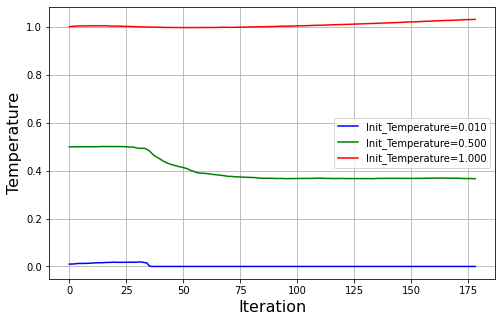

In [3]:
Color = ['blue', 'green', 'red', 'yellow', 'pink']

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
for i in range(len(TemperatureList)):
  ax.plot(TemperatureList[i][1:], Color=Color[i], label='Init_Temperature=%.3f'%TemperatureParameters[i])
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Temperature", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

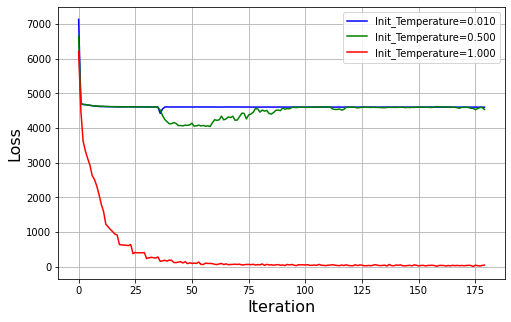

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
for i in range(len(TemperatureParameters)):
  ax.plot(LossList[i], Color=Color[i], label='Init_Temperature=%.3f'%TemperatureParameters[i])
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [30]:
# for i in range(len(TemperatureParameters)):
#   print(LossList[i])

[7138.349941730499, 4714.023993015289, 4680.722389221191, 4681.0677934885025, 4668.122446537018, 4656.646456003189, 4647.931197762489, 4636.212497472763, 4629.695187330246, 4624.8181529045105, 4623.815935850143, 4621.756496667862, 4622.987468719482, 4618.688956022263, 4617.873698949814, 4617.600073337555, 4616.058462142944, 4614.25394320488, 4611.893015384674, 4613.148740530014, 4616.528702259064, 4614.219186306, 4617.546698451042, 4614.203653335571, 4615.051007270813, 4614.743226528168, 4615.165512084961, 4613.40248966217, 4612.720946311951, 4612.289411306381, 4611.451451063156, 4612.816719532013, 4610.859222650528, 4610.571267366409, 4611.365359067917, 4611.267815113068, 4424.828273892403, 4550.999169826508, 4609.506725072861, 4612.480417251587, 4610.220499277115, 4609.890972137451, 4610.344839334488, 4611.734804391861, 4612.481854438782, 4611.295848608017, 4609.417740345001, 4611.216052770615, 4612.375955581665, 4610.558088302612, 4610.169030666351, 4609.721885204315, 4612.745107173

In [25]:
# for i in range(len(TemperatureParameters)):
#   print(TemperatureList[i][1:])

[array(0.00931561, dtype=float32), array(0.00934969, dtype=float32), array(0.00960534, dtype=float32), array(0.01003217, dtype=float32), array(0.01107378, dtype=float32), array(0.01220662, dtype=float32), array(0.01206046, dtype=float32), array(0.01209398, dtype=float32), array(0.01231895, dtype=float32), array(0.01292881, dtype=float32), array(0.01289468, dtype=float32), array(0.01332377, dtype=float32), array(0.0145466, dtype=float32), array(0.01490621, dtype=float32), array(0.01483732, dtype=float32), array(0.01522848, dtype=float32), array(0.01547695, dtype=float32), array(0.0164261, dtype=float32), array(0.01629528, dtype=float32), array(0.01677168, dtype=float32), array(0.01696039, dtype=float32), array(0.01734481, dtype=float32), array(0.01677366, dtype=float32), array(0.01680984, dtype=float32), array(0.0168497, dtype=float32), array(0.01678585, dtype=float32), array(0.0168885, dtype=float32), array(0.01689771, dtype=float32), array(0.01722102, dtype=float32), array(0.01730301,